# Machine Learning SoSe21 Practice Class

Dr. Timo Baumann, Dr. Özge Alaçam, Björn Sygo <br>
Email: baumann@informatik.uni-hamburg.de, alacam@informatik.uni-hamburg.de, 6sygo@informatik.uni-hamburg.de

## Exercise 7
**Description:** Implement and simulate a multi-armed bandit  <br>
**Deadline:** Saturday, 03. July 2021, 23:59 <br>
**Working together:** You can work in pairs or triples but no larger teams are allowed. <br>
&emsp;&emsp;&emsp; &emsp; &emsp; &emsp; &emsp; Please adhere to the honor code discussed in class. <br>
&emsp;&emsp;&emsp; &emsp; &emsp; &emsp; &emsp; All members of the team must get involved in understanding and coding the solution.

## Submission: 
**Moritz Lahann**

*Also put high-level comments that should be read before looking at your code and results.*

### Goal
In this exercise, you will implement basic RL techniques for the multi-armed bandit problem. Unlike in the previous tasks, this one does not require _data_ but a specification of a _World_, an _Agent_ and a simulation environment that supervises the performance of the agent in the world and measures its succcess. In other words: you first need to design your experimentation environment.

### Design the interfaces of your simulation environment
You want to separate the agent and the world and specify the interfaces of the agent and the world that it interacts with. You will then supervise the interaction in your simulation environment.

**Task 1** (15%):
To this end, define the interfaces for:
 * a k-armed bandit world (each arm's reward is normally distributed with $\sigma=1$ and each mean is chosen normally with $\mu=1$ and $\sigma=1$), 
 * a k-armed bandit agent that plays in the world and is able to be informed about the rewards for its actions.
Note that it may be easier in Python to specify classes (with minimal behaviour) rather than interfaces. For example, your minimal agent could simply pull one of the arms at random.

**Task 2** (10%): Define a simulation environment implementation that orchestrates the interplay between the agent and the world for a given number of action-reward rounds while keeping track of the relevant performance metrics that later need to be visualized (see below).

Results of individual runs of the simulation will be very noisy. Therefore, define a way to repeatedly play the simulation (say, 2000 times) and average the performance metrics across these episodes.

Perform your experiments with a $k=10$-armed bandit and episodes of $N=1000$ action-reward rounds, but make sure that your implementation also works for different $k$ and $N$.

Note: analyse the requirements of the simulation environment wrt. the tasks specified below to ensure that you do all that is necessary (and not too much else).

In [33]:
import random
import numpy as np
import matplotlib.pyplot as plt

def argmax(list):
    return max(range(len(list)), key=lambda i: list[i])

class BaseWorld:
    def __init__(self, k):
        self.arms = [random.gauss(mu=1, sigma=1) for _ in range(k)]
    
    def get_reward(self, arm):
        return random.gauss(mu=self.arms[arm], sigma=1)

    def nr_arms(self):
        return len(self.arms)

    def after_iteration(self):
        pass

class BaseAgent:
    def __init__(self, world):
        self.world = world
        self.possible_actions = world.nr_arms()

    def initialize(self):
        self.weights = [1 / self.possible_actions] * self.possible_actions

    def select_action(self):
        self.action = random.choices(range(self.possible_actions), weights=self.weights, k=1)[0]

    def perform_action(self):
        self.action_weight = self.weights[self.action]
        reward = self.world.get_reward(self.action)
        self.reward = reward
        self.update()
        return reward, self.action_weight

    def update(self):
        pass

    def info():
        return "Random Choice Agent"

class Simulation:
    def __init__(self, agent, world, k, n):
        self.world = world(k)
        self.agent = agent(self.world)
        self.epochs = n

    def run_sim(self):
        self.rewards = []
        self.proportions = []
        self.agent.initialize()
        for e in range(self.epochs):
            self.agent.select_action()
            reward, best_action_proportion = self.agent.perform_action()
            self.rewards.append(reward)
            self.proportions.append(best_action_proportion)
        return self.rewards, self.proportions

class Experiment:
    def __init__(self, world, k, n):
        self.world = world
        self.k = k
        self.n = n

    def run_experiment(self, repetitions, agent):
        self.repetitions = repetitions
        self.agent = agent
        self.rewards = np.zeros((repetitions, self.n))
        self.proportions = np.zeros((repetitions, self.n))
        for index in range(repetitions):
            sim = Simulation(agent, self.world, self.k, self.n)
            r, p = sim.run_sim()
            self.rewards[index] = r
            self.proportions[index] = p

    def compare_agents(self, repetitions, agents):
        assert type(agents) == list
        self.repetitions = repetitions
        self.agents = agents
        self.rewards = np.zeros((len(agents), repetitions, self.n))
        self.proportions = np.zeros((len(agents), repetitions, self.n))
        for i_agent, agent in enumerate(agents):
            for i_rep in range(repetitions):
                sim = Simulation(agent, self.world, self.k, self.n)
                r, p = sim.run_sim()
                self.rewards[i_agent, i_rep] = r
                self.proportions[i_agent, i_rep] = p

    def plot(self):
        avg_rewards = np.mean(self.rewards, axis=0)
        avg_proportions = np.mean(self.proportions, axis=0)
        
        plt.plot(range(len(avg_rewards)), avg_rewards)
        plt.xlabel("Rewards")
        plt.title(f"Reward progression for {self.agent.info()}")
        # plt.subtitle(f"Averaged over {self.repetitions} iterations")
        plt.show()

        plt.plot(range(len(avg_proportions)), avg_proportions)
        plt.xlabel("Weight")
        plt.title(f"Proportion of best action chosen for {self.agent.info()} ")
        # plt.subtitle(f"Averaged over {self.repetitions} iterations")
        plt.show()

    def plot_compare(self):
        avg_rewards = np.mean(self.rewards, axis=1)
        avg_proportions = np.mean(self.proportions, axis=1)
        print(avg_rewards.shape)


### Visualization
**Task 3** (10%): Plot the performance of an agent over time (i.e., the action-reward rounds) in terms of reward achieved and proportion of best action chosen. Test the visualization by running your trivial agent (which just randomly pulls any trigger): you should not notice any improvements over time.

Note: it will be convenient if your visualization functionality can plot results from multiple different agents/agent runs to simplify comparison.

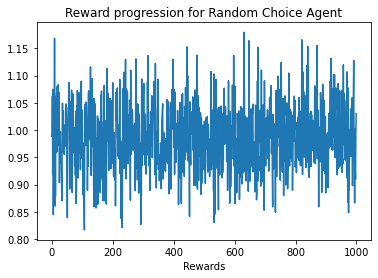

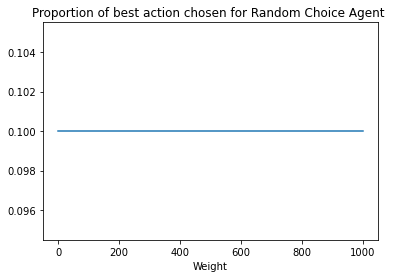

In [32]:
e = Experiment(world=BaseWorld, k=10, n=1000)
e.run_experiment(repetitions=500, agent=BaseAgent)
e.plot()

### Implement Reinforcement Learning

**Task 4** (35%): Implement k-armed bandit agents for your environment. In particular, implement an $\varepsilon$-greedy agent with fixed $\varepsilon$ (experiment with $\varepsilon \in {0, 0.01, 0.1, 1}$) and one with UCB action selection. Your basic agents may make use of the length of the episode $N$.

Furthermore, build some of the variations of $\varepsilon$-greedy agents: optimistic initialization and allowing for arbitrarily long episodes (i.e., not using incremental Q computation).

In your implementation, try to build an abstraction hierarchy that avoids re-writing code shared by multiple agent types.

**Task 5** (10%): Simulate learning over 2000 episodes and visualize the results. Discuss your findings for the different settings and the various learning strategies that you have implemented.



In [34]:
class GreedyAgent(BaseAgent):
    def __init__(self, world, epsilon):
        super().__init__(world)
        self.epsilon = epsilon
        self.counts = [0] * self.possible_actions

    def select_action(self):
        if random.random() <= self.epsilon:
            self.action = random.choice(range(self.possible_actions))
        else:
            self.action = argmax(self.weights)

    def update(self):
        self.counts[self.action] += 1
        learning_rate = 1 / self.counts[self.action]
        self.weights[self.action] += learning_rate * (self.reward - self.weights[self.action])

In [35]:
e = Experiment(world=BaseWorld, k=10, n=1000)
e.run_experiment(repetitions=500, agent=GreedyAgent)
e.plot()

TypeError: __init__() missing 1 required positional argument: 'epsilon'

### Reward drift
**Task 6** (20%): Implement a world in which rewards of each action change gradually. Implement an agent that is suitable for such a world and compare its behaviour against the standard $\varepsilon$-greedy agent. 

### Hint

More detailed information about this topic you can find in Sutton&Barto Ch. 2, which is uploaded on Moodle.

### Report Submission

Prepare a report of your solution as a commented Jupyter notebook (using markdown for your results and comments); include figures and results.
If you must, you can also upload a PDF document with the report annexed with your Python code.

Upload your report file to the Machine Learning Moodle Course page. Please make sure that your submission team corresponds to the team's Moodle group that you're in.